In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.font_manager as fm
import folium

In [2]:
file_path = '../data/'

df = pd.read_csv(os.path.join(file_path, 'processed_data.csv'))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1951400 entries, 0 to 1951399
Data columns (total 21 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   index                           int64  
 1   area_m2                         float64
 2   contract_year_month             int64  
 3   contract_day                    int64  
 4   contract_type                   int64  
 5   floor                           int64  
 6   built_year                      int64  
 7   latitude                        float64
 8   longitude                       float64
 9   age                             int64  
 10  deposit                         float64
 11  _type                           object 
 12  nearest_subway_distance_km      float64
 13  year_month_date                 object 
 14  interest_rate                   float64
 15  prev_month_interest_rate        float64
 16  nearest_elementary_distance_km  float64
 17  nearest_middle_distance_km 

In [4]:
def reduce_mem_usage(df):
    """
    Iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2  # Memory usage before optimization
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2  # Memory usage after optimization
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 312.65 MB
Memory usage after optimization is: 107.94 MB
Decreased by 65.5%


In [6]:
train_df = df.loc[df['_type'] == 'train'].drop('year_month_date', axis=1)
test_df = df.loc[df['_type'] == 'test'].drop('year_month_date', axis=1)

In [7]:
# 한글 폰트 사용시 마이너스 깨지는 문제 
matplotlib.rcParams['axes.unicode_minus'] = False

#폰트 경로
font_path = "/usr/share/fonts/NanumFont/NanumGothicBold.ttf"
 
#폰트 이름 얻어오기
font_name = fm.FontProperties(fname=font_path).get_name()

plt.rcParams["font.family"] = font_name
plt.rcParams["font.size"] = 15

In [8]:
years = df['contract_year_month'].astype(str).str[:4].unique()
years

array(['2019', '2020', '2021', '2022', '2023', '2024'], dtype=object)

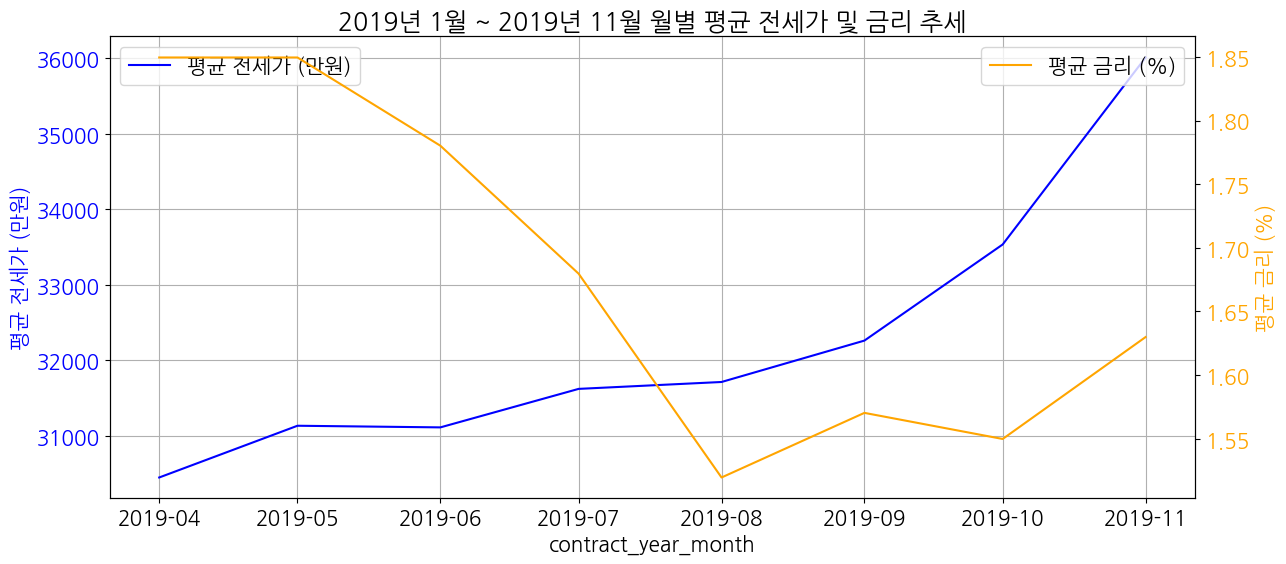

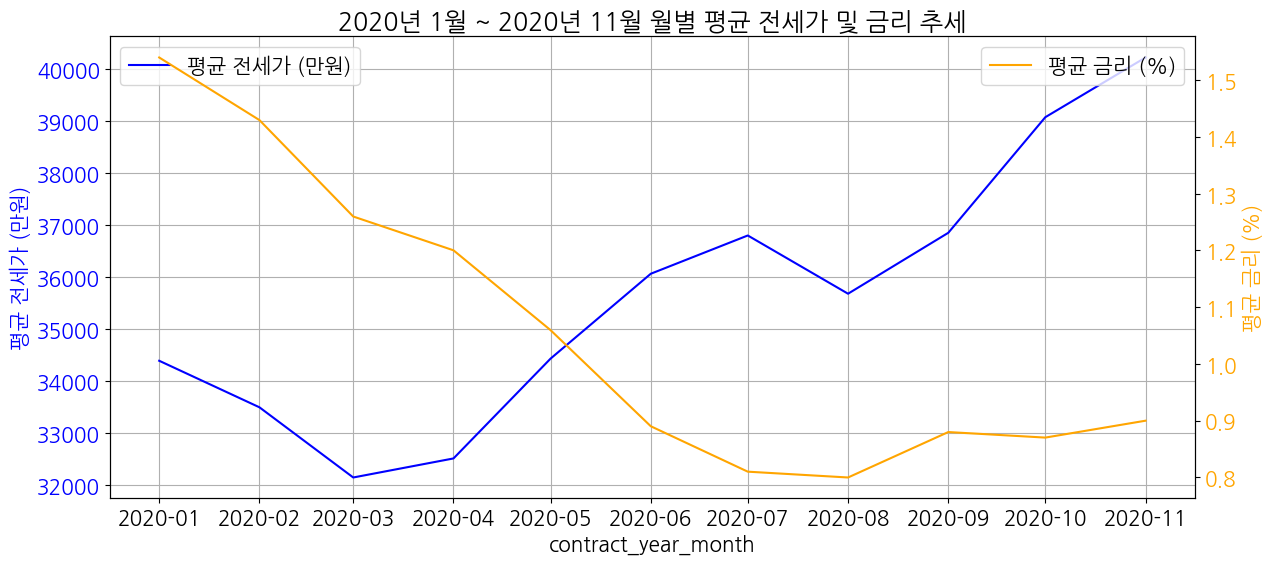

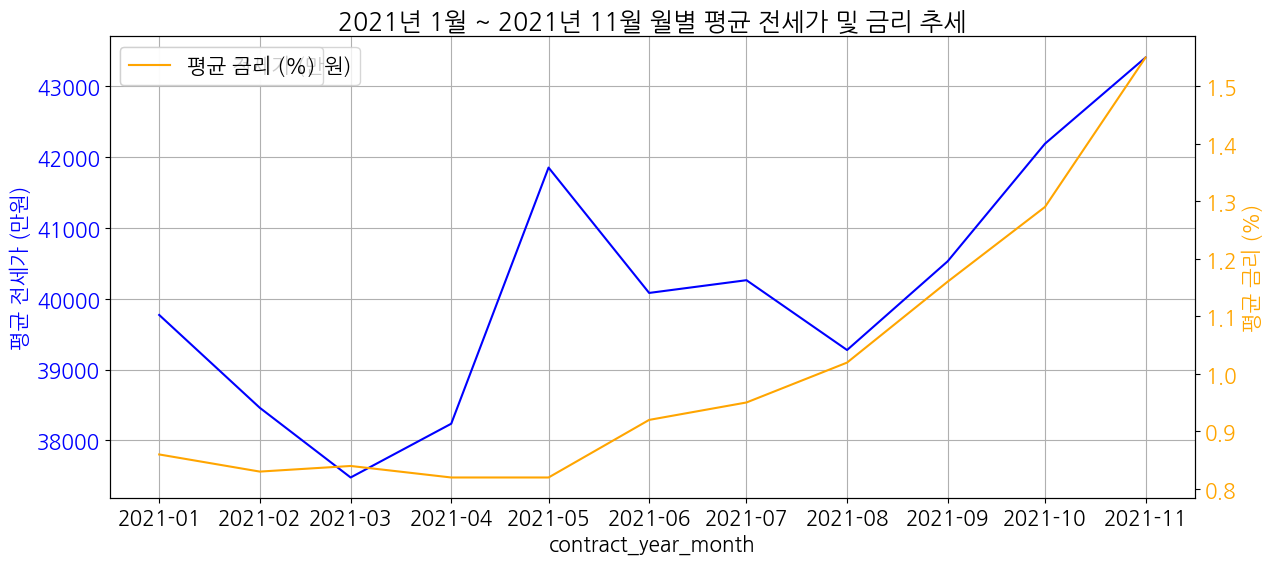

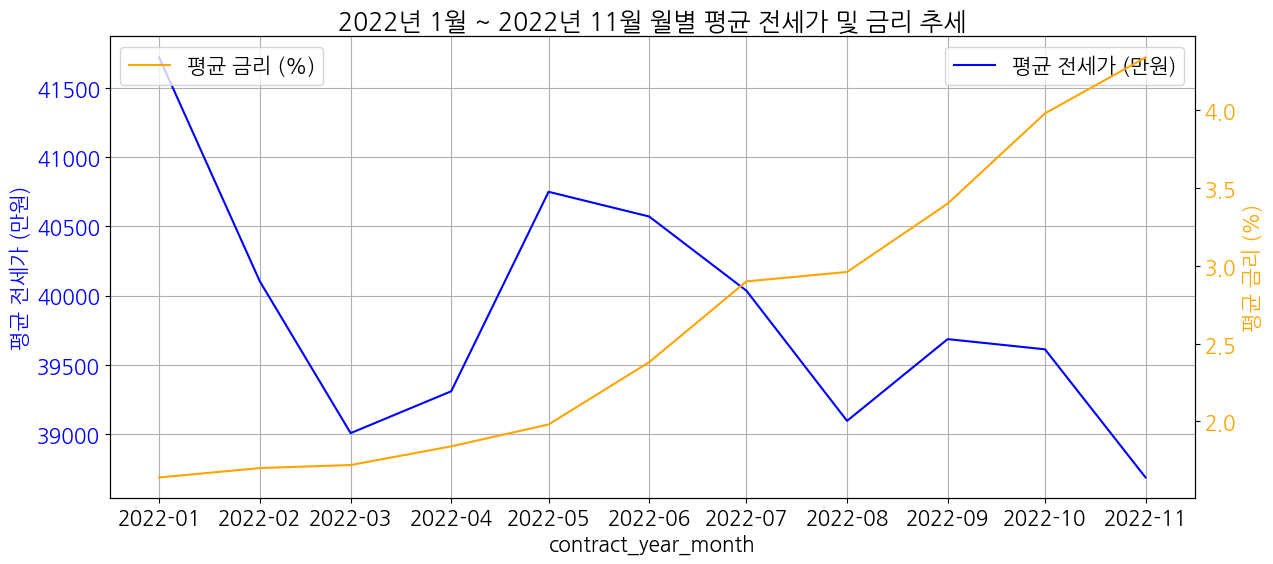

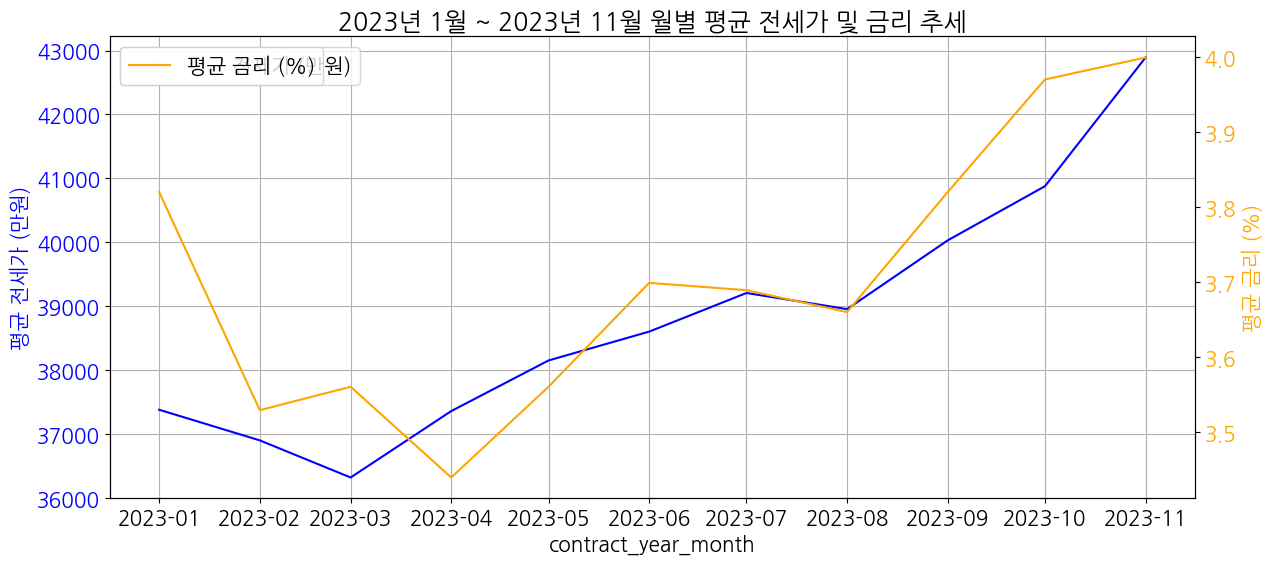

In [9]:
def plot_time_series_with_interest(df, x, y1, y2, title, xlabel, ylabel1, ylabel2, figsize=(14, 6)):
    fig, ax1 = plt.subplots(figsize=figsize)

    # 첫 번째 y축: 전세가
    sns.lineplot(x=x, y=y1, data=df, ax=ax1, color='blue', label=ylabel1)
    ax1.set_ylabel(ylabel1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # 두 번째 y축: 금리
    ax2 = ax1.twinx()
    sns.lineplot(x=x, y=y2, data=df, ax=ax2, color='orange', label=ylabel2)
    ax2.set_ylabel(ylabel2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title(title)
    plt.xlabel(xlabel)
    ax1.grid()
    plt.show()

def plot_monthly_avg_deposit_multiple_year_ranges_with_interest(df):
    # 각 연도 범위 설정
    year_ranges = [
        (2019, 1, 2019, 11),
        (2020, 1, 2020, 11),
        (2021, 1, 2021, 11),
        (2022, 1, 2022, 11),
        (2023, 1, 2023, 11),
        (2024, 1, 2024, 6)
    ]
    
    for start_year, start_month, end_year, end_month in year_ranges:
        # 시작과 끝 날짜를 정수로 변환
        start_date = start_year * 100 + start_month
        end_date = end_year * 100 + end_month + 1  # 포함하기 위해 +1
        
        # 연도 범위에 해당하는 데이터 필터링
        df_filtered = df[(df['contract_year_month'] >= start_date) & (df['contract_year_month'] < end_date)]
        
        if not df_filtered.empty:
            # 월별 평균 전세가 계산
            monthly_avg_deposit = df_filtered.groupby('contract_year_month')['deposit'].mean().reset_index()
            monthly_avg_interest = df_filtered.groupby('contract_year_month')['interest_rate'].mean().reset_index()
            
            # 계약 연월을 날짜 형식으로 변환
            monthly_avg_deposit['contract_year_month'] = pd.to_datetime(monthly_avg_deposit['contract_year_month'].astype(str), format='%Y%m')
            monthly_avg_interest['contract_year_month'] = pd.to_datetime(monthly_avg_interest['contract_year_month'].astype(str), format='%Y%m')
            
            # 두 데이터프레임 병합
            monthly_avg = pd.merge(monthly_avg_deposit, monthly_avg_interest, on='contract_year_month')

            # 라인 차트 시각화
            plot_time_series_with_interest(monthly_avg, 'contract_year_month', 'deposit', 'interest_rate', 
                                            f'{start_year}년 {start_month}월 ~ {end_year}년 {end_month}월 월별 평균 전세가 및 금리 추세', 
                                            '계약 연월', 
                                            '평균 전세가 (만원)', 
                                            '평균 금리 (%)')

# 모든 연도 범위에 대한 월별 평균 전세가 및 금리 추세 시각화
plot_monthly_avg_deposit_multiple_year_ranges_with_interest(train_df)

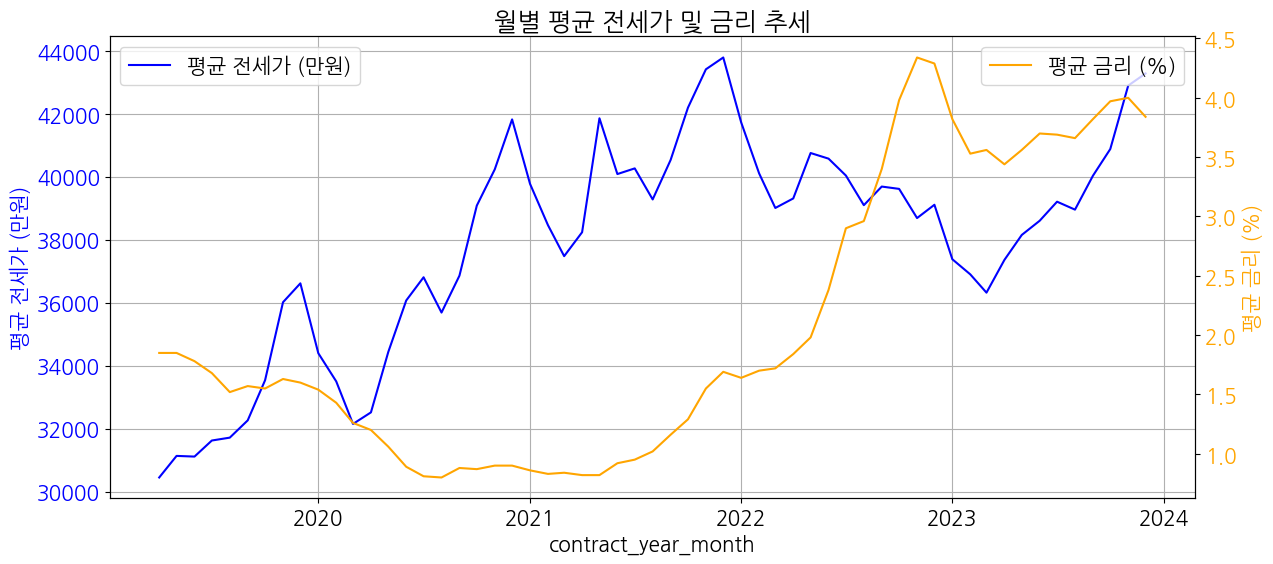

In [10]:
def plot_monthly_avg_deposit_with_interest(df):
    # 월별 평균 전세가 및 금리 계산
    monthly_avg_deposit = df.groupby('contract_year_month')['deposit'].mean().reset_index()
    monthly_avg_interest = df.groupby('contract_year_month')['interest_rate'].mean().reset_index()

    # 계약 연월을 날짜 형식으로 변환
    monthly_avg_deposit['contract_year_month'] = pd.to_datetime(monthly_avg_deposit['contract_year_month'].astype(str), format='%Y%m')
    monthly_avg_interest['contract_year_month'] = pd.to_datetime(monthly_avg_interest['contract_year_month'].astype(str), format='%Y%m')

    # 두 데이터프레임 병합
    monthly_avg = pd.merge(monthly_avg_deposit, monthly_avg_interest, on='contract_year_month')

    # 라인 차트 시각화
    plot_time_series_with_interest(monthly_avg, 'contract_year_month', 'deposit', 'interest_rate', 
                                    '월별 평균 전세가 및 금리 추세', 
                                    '계약 연월', 
                                    '평균 전세가 (만원)', 
                                    '평균 금리 (%)')

# 월별 평균 전세가 및 금리 추세 시각화
plot_monthly_avg_deposit_with_interest(train_df)

In [11]:
###계약시점 건물의 나이 & 재건축 -> 
###전세가격 % 매매가격 
###전세가율 up 거품 <-> 건물의나이이

In [16]:
numeric_df = train_df.select_dtypes(include=['float32', 'float16', 'int32', 'int16', 'int8'])

# 선택된 숫자형 변수 확인
print("Numeric columns:", numeric_df.columns)

Numeric columns: Index(['index', 'area_m2', 'contract_year_month', 'contract_day',
       'contract_type', 'floor', 'built_year', 'latitude', 'longitude', 'age',
       'deposit', 'nearest_subway_distance_km', 'interest_rate',
       'prev_month_interest_rate', 'nearest_elementary_distance_km',
       'nearest_middle_distance_km', 'nearest_high_distance_km',
       'nearest_park_distance_km', 'nearest_park_area'],
      dtype='object')


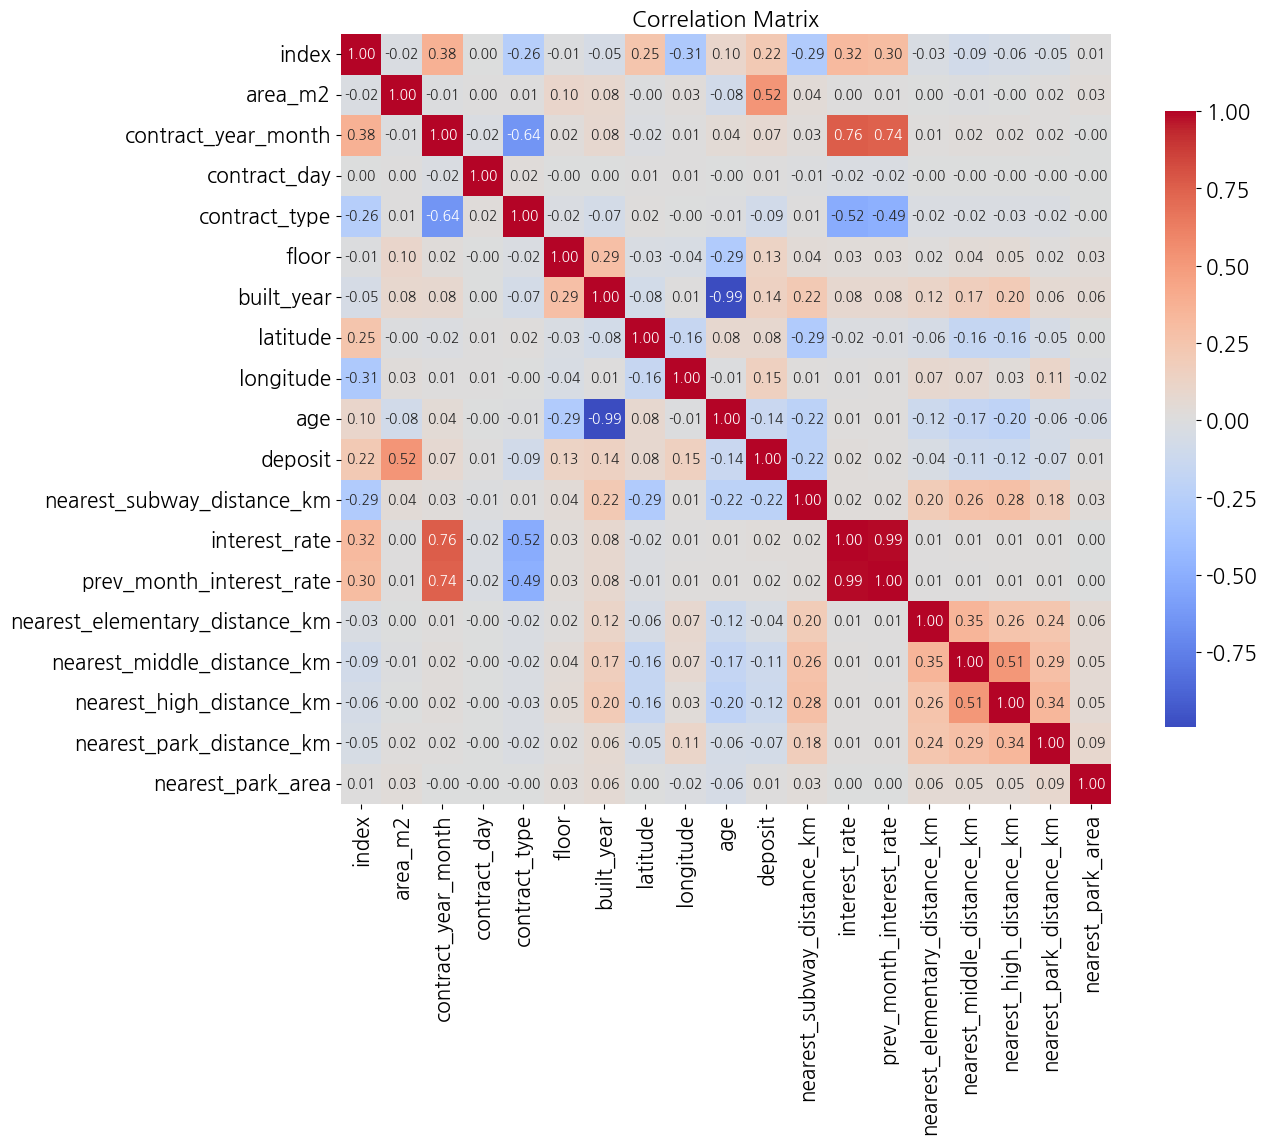

In [18]:
correlation_matrix = numeric_df.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(14, 10))  # 그림 크기 조정
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
            annot_kws={"size": 10},  # 글자 크기 조정
            cbar_kws={"shrink": .8})  # 색상 바 크기 조정
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
train_df['contract_year_month'] = pd.to_datetime(train_df['contract_year_month'].astype(str), format='%Y%m')

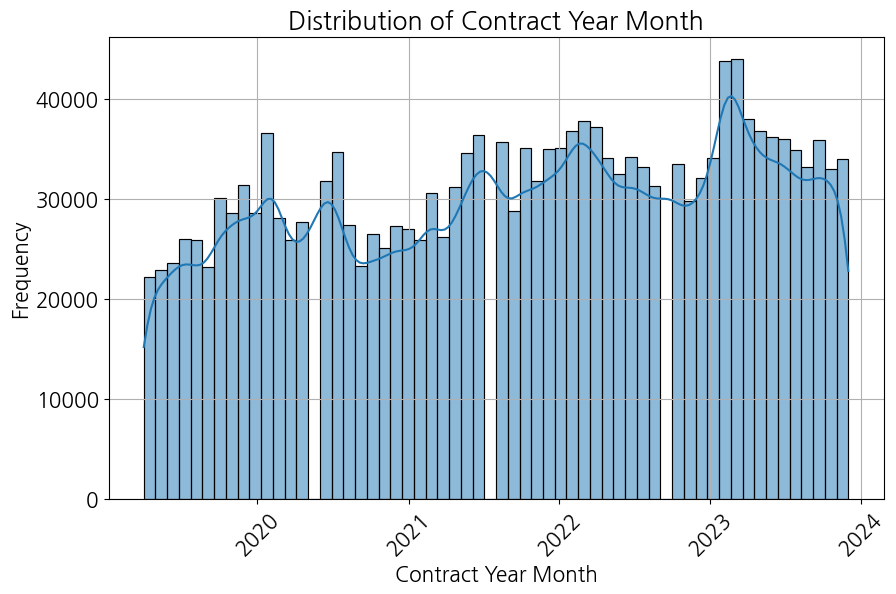

In [40]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.histplot(train_df['contract_year_month'], kde=True, bins=60)
plt.title('Distribution of Contract Year Month')
plt.xlabel('Contract Year Month')
plt.ylabel('Frequency')
plt.grid()
plt.xticks(rotation=45)
plt.show()

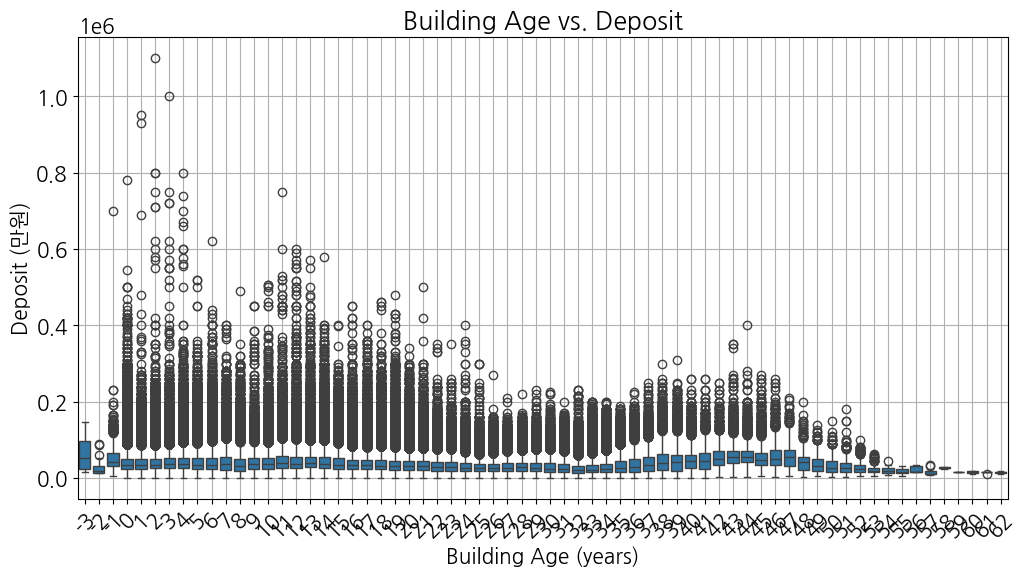

In [29]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='age', y='deposit', data=train_df)
plt.title('Building Age vs. Deposit')
plt.xlabel('Building Age (years)')
plt.ylabel('Deposit (만원)')
plt.xticks(rotation=45)
plt.grid()
plt.show()